In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '5class-weather-status-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2405622%2F4063112%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T073519Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D44fdf7a0a7efef446786a69a20ea9c1ebe875f26f55f98023950119c41771d8d0f8b3d388c4890c7fd5b7127b3139694080c9f62cb4e622574a5739579e0c0d0f76f72c800449ccd55adcea8ee47ee07edeeabea294eb03d88ada135e02b5f5a91e74a9925c67d1a2c5210b2a3c3f72426826772e02a2aa303af326c68ab0d834a4319555f43020cdef43ecb9c4287455f58f5f0f68e0e04c176084ee3140fd1936230ac3f887a3c9b2cb8f9795182e74517afe89f960c29ddce9c152b16aca379d3c42c4ace3fe31455a6552522e1a06a9eaa16b9a00753deec0fc5a3b54c55ed6271ea906643ab36168e318cf2370506cffc2909cf646d616260dc01a7a7b0,ft-resnet-model-200:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5088307%2F8521760%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T073519Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2c4699e2cd93e3cbcfe406dc96ddd5528533103d0418e923b248993f978df226e5757140c74aef8c20b232a2e247c6a389b636c98c7396020fc3ef63be52945dbee751c3216f32a5992ecbea6ff7a92c777d236268915ff2335e8b52f040026bad5e2d731908478517b412996b014b559a5b2110b305f4c41898b0bcaf2d0239d82397b1b911eee16d71e8906c53b92a1932f06cb522beca401e96d8af084bf412d3f3d871bde6fe5c34560b47736847d3207657246ac53fe63f205abb87e51b7e7d2fedb55e46e80f50deddccb3be063ebd8ebeff8d8ea7f3bf0861511a8f752087cca3b78f7e5e6dc111773b2056fa4116e692423065bbb4d47a750eb0e37c,image-test-1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5088436%2F8521926%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T073520Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6af8ceb4cf60f1ada190be87084faa7bd761f2cdd694b9eb5ad7ddc2f5e8463ddc05cea502bc36c797834653e8a16c28634c5dddda18310c9e4bdb29ba614ef291704110d724bbdcecea64484dba36f4bfe67117fe9707d9d025fa068f52c63c5f111a30f3cd6fccf7292ac1de7e5792059f1916d96cfb59ac785958aeb2f31666f419d1c48cbf5c278dfeccc412e98d5666ba2c6703ec8088389f39359228f6ceac25d264bb86d09ee5e32f8a757f4ff2436819ea219a7f46f2d216bf140ec218949443056833e3bff69a151b46254f9edfcaafeeb5ae24d02ccba70cca4ff4fade109ae1efa9bf6be0f23730f8cd32b014c1ba5a4bdf959f412a237a77c288,image-rainy:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5088718%2F8522306%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T073520Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1a769e66bac5666dce350bede65a0ac9404a58074cc4432bf9b69b76a38e4dae7aa3e6666faff41c495c4b71d7daaa1d8b4fb4b1a4f179294be3b51faa2d19bf131d70d46d5316b011dbcc9242badb2507e2dc6886a0f03b627b804ddd873c7ff20b8b9ecc42c4e09a32b6d02f3fad0292f09a3936cc3811b56a5f8ff2e92bc67b32ebe8ea0e288eaf77484dbdc528bb94be4988c1e983a858b83bb3c7419f9a0ff521934715d854c3fcce8cc7bc7026d82d6cc9269b993fe6881e65787bc76be67b1b73274c3def7010ded4dd20772dea60ee2e1956c86ddf77655e3fda17b775418306a58f9fcd0f258760204f9daf091dac604654bd973e9563ed3725ef44,image-rainy-3:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5088747%2F8522343%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T073520Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1268135835759287d592a63285fec883579c70ac3547eadf80dc6f076650ae153b2c015494d16e81fa199b7e9a083e8d47f1aa323f1a44beee63038c6e9b978f22835b3eac6529085adc927a7fe597ef96b99fe10ba5499865c90de1e8b46570ef04893f1a7ac3b5314a2e0f8096c1598664f1ffdf1c8ddb5222bc5df71b48783489abe643c353943905e5821274ab4c676319b38690f51e1bc5354f7d60476de124b702a3bdb3ce21c488525297917152a4235c0a3d354fb28ee6a7901a6771226bf45dbc8742091f9830a6f71f725d3cb38ce2a16c1f89898c0be582e940bc302760050fca9bfd53dbc1736f7581f3391906b91003b42abc9bcd33f953b63a,rainy-4:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5088946%2F8522626%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T073520Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7e0a7747d4ada958d859958f83ded36d8506eb06a1ff24ab9d3ae2de7fa7e56083116aeaa4fffbb7c14f89985c9734de60b3537f37fc9ac7cbc682a74bc0cd3f58349663d82f5131e67c92ed12801f06ca4bc7342b5efe07470206f72e9d9759596dc2f9711f2707308d39e15ac518b237bdca134da41045f8e324a84a376b38d4bcd848e26cb0382367463e232f4336632aed06014e44f6ff67eb0737d866cac5f5447b8eae3eb8cfe0529edc8afc9df187b8e0982b491fa2411be57673b5a1a18f4a60e3db15d96dff4d5a2a12969106c06ca3ab0657385d93a2961756bc6a4b7dd82abcfabb8c93e5730823fae36eb2b8a0901e88ec99dd5b10e7f3ae81c9,rainy-5:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5088950%2F8522631%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T073520Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7afce04dd971b88652095fc46611f32de51fabbfa3c7eb37eeead3bf7a78f39fd6cc9a59d3c73993012aafe999cdf690ee58b5b2926f42c359fe56dccf088525a51f0852df229d786b69675de04fc2e608ee3a9514ecd7fc635b9589b03b5e9cd64230947cae55732c079539eedc8b87dac2ae0a8e0446db51f2472099a650a9688076597ccbe4d933a00d8d91e7f1418254c7ba6a0eab0fe146bcb8989a2d88748937bfab39cf1fe817bbb0b7513a1307da1bb988a2659614a95e59c4f4912aab1d95cf05492c661206d53a9a4cb709029eafeec843c8d1e784d52ea94ee69cca95628a05bb57cc8cdb4ee4d903e238c14dd87787aaa7830d6a8047299d6516,cloudy-1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5162878%2F8623984%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T073520Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da76a2dc5a8b05d6fa6b24ae3ccdd4f3b4a399a3f47643493047377f1fa10f60d3acd7350fd666479400f73970bc1da5be05ba65c11585ddd8d630fa914ef59ea913b3322b3264aee1712544db239d3f6d4b4bbec1f4a40cb8d21f70c22d3566239fd359813017120bbbbb002e926131dbabd4e59aadd956e0e806d6f0bc65b6492007245989f209ed6f8624c9118b18f3225bc20a8a02d8f42e501aa4400657d0b7b45b7f16d7b0f59e88bf4c1352906bf34fcf85bfd935428261794073623624b9e70b77ab79d5459f43f5db1a2a327131de92c437d3c55dc3265a1a8ad7123031df994881a6d18c9affc8d21180fce30bd3a9b6418462403604ed2dec18dc7,cloudy-2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5162886%2F8623993%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T073520Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D339279d5e2a2ab56d85029d862c02d0941774573ad18d5e7762ef2c9b05faa63cb64b2462e83673c757175c7b7b010604f1e1abdb90444ba8cbfdbc0ad8f0da6ef02c85d826cf7ebb2673c560657551e7d1757314cf5bc071bdd23c86eacc27c58c02b8655ac214fbdce95d51a16a5b81200b2a1e52fe137cecaf3f714336fdc479c2193550669c28eddd2370320c90d643036c9cf252cbb169405137db76bb1e41848849f9657a9c491962896d9d7b4f55429d4435fc58d15451d30bad64112c1a6deb8d472d8a19b50e00ea11be3090b7d08077bfbfb890bff492789a75d7d94ae19483cf4ee9e6b70f6463b9bd8f22465875b1bef839618eb52692d59d76b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
from sklearn.model_selection import StratifiedShuffleSplit
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torchvision
import torchvision.models as models
from PIL import Image

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
root_dir = '/kaggle/input/5class-weather-status-image-classification/data'

classes = {
    idx: class_name for idx, class_name in enumerate(os.listdir(root_dir))
}

In [ ]:
img_paths = []
labels = []

for idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(idx)

In [ ]:


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_full_idx, test_idx = next(split.split(img_paths, labels))

X_train_full = []
y_train_full = []
X_test = []
y_test = []

for i in train_full_idx:
    X_train_full.append(img_paths[i])
    y_train_full.append(labels[i])

for i in test_idx:
    X_test.append(img_paths[i])
    y_test.append(labels[i])

X_train = []
y_train = []
X_valid = []
y_valid = []

train_idx, valid_idx = next(split.split(X_train_full, y_train_full))

for i in train_idx:
    X_train.append(X_train_full[i])
    y_train.append(y_train_full[i])

for i in valid_idx:
    X_valid.append(X_train_full[i])
    y_valid.append(y_train_full[i])

In [ ]:
class WeatherDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.img_paths = X
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, label = self.img_paths[idx], self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
IMG_SIZE = 224
batch_size = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomCrop(IMG_SIZE, padding=2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    transforms.RandomErasing(p=0.75,
                             scale=(0.01, 0.3),
                             ratio=(1.0, 1.0),
                             value=0,
                             inplace =True)
])

valid_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])
])

trainset = WeatherDataset(X_train, y_train, transform=train_transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

validset = WeatherDataset(X_valid, y_valid, transform=valid_transform)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False)

In [ ]:
testset = WeatherDataset(X_test, y_test, transform=valid_transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 170MB/s]  


In [ ]:
for child in model.children():
    count = 0
    for layer in child.parameters():
        count += 1
    print(count)


1
2
0
0
30
75
327
30
0
2


In [ ]:
num_classes = 5
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model = model.to(device)

In [ ]:
model.load_state_dict(torch.load('/kaggle/input/ft-resnet-model-200/fine_tuning_resnet_model_200.pt'))

<All keys matched successfully>

In [ ]:
# print(model)
type(model)

torch.nn.parallel.data_parallel.DataParallel

In [ ]:
IMG_SIZE = 224

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])
])

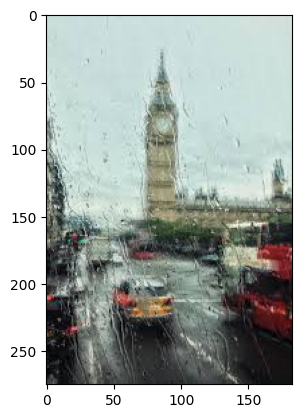

In [ ]:
from PIL import Image

img_path = '/kaggle/input/image-rainy-3/mua_3.jpg'

image = Image.open(img_path).convert('RGB')
plt.imshow(image)

In [ ]:
image = transform(image)
image = image.unsqueeze(0)
image = image.to(device)
model.eval()
output = model(image)

In [ ]:
output

tensor([[-3.7894, -1.6208, -2.3940, -4.1713,  2.6461]], device='cuda:0',
       grad_fn=<GatherBackward>)

In [ ]:
_, predicted = torch.max(output.data, dim=1)
predicted

tensor([4], device='cuda:0')

In [ ]:
predicted[0].item()

4

In [ ]:
import os

root_dir = '/kaggle/input/5class-weather-status-image-classification/data/rainy'
pred = []

count = 0
model.eval()

with torch.no_grad():
    for img_path in os.listdir(root_dir):
        if count < 100:
            image_path = os.path.join(root_dir, img_path)
            img = Image.open(image_path).convert('RGB')
            img = transform(img)
            img = img.unsqueeze(0)
            img = img.to(device)
            output = model(img)
            _, predicted = torch.max(output.data, dim=1)
            pred.append(predicted)
        else:
            break
        count += 1

In [ ]:
pred_1 = torch.cat(pred, dim=0)
pred_1 = pred_1.cpu().numpy()
print((pred_1==4).sum())

92


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
import os

root_dir = '/kaggle/input/5class-weather-status-image-classification/data'

classes = {
    idx: class_name for idx, class_name in enumerate(os.listdir(root_dir))
}

In [ ]:
classes

{0: 'sunny', 1: 'cloudy', 2: 'snowy', 3: 'foggy', 4: 'rainy'}

In [ ]:
def prediction(model, img_path):
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    model.eval()
    output = model(img)
    _, predicted = torch.max(output.data, dim=1)
    print(classes[predicted[0].item()])
    return output


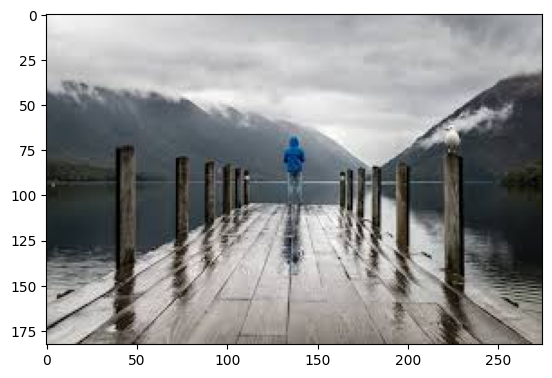

In [ ]:
from PIL import Image

img_path = '/kaggle/input/cloudy-2/cloudy_2.jpg'

image = Image.open(img_path).convert('RGB')
plt.imshow(image)

In [ ]:
output = prediction(model, img_path)

rainy


In [ ]:
output

tensor([[-6.3403, -0.7373, -1.6101, -3.1674,  1.4647]], device='cuda:0',
       grad_fn=<GatherBackward>)

In [ ]:
img_path = '/kaggle/input/image-test-1/mua_2.jpg'
prediction(model, img_path)

rainy


In [ ]:
img_path = '/kaggle/input/image-rainy/mua.jpg'
prediction(model, img_path)

cloudy


In [ ]:
img_path = '/kaggle/input/rainy-4/mua_4.jpg'
prediction(model, img_path)

rainy


In [ ]:
img_path = '/kaggle/input/rainy-5/mua_5.jpg'
prediction(model, img_path)

rainy


In [ ]:
y_pred = []

def evaluate(model, testloader):
    model.eval()
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, dim=1)
        y_pred.append(predicted)

In [ ]:
evaluate(model, testloader)

In [ ]:
y_pred = torch.cat(y_pred, dim=0).cpu().numpy()

In [ ]:
labels_test = []
for _, labels in testloader:
    labels_test.append(labels)

y_actual = torch.cat(labels_test, dim=0).cpu().numpy()

In [ ]:
total_class = np.zeros(5)
for i in range(5):
    total_class[i] = (y_actual==i).sum()

def class_accuracy(y_actual, y_pred):
    accuracies = np.zeros(5)
    for i in range(len(y_actual)):
        if y_actual[i] == y_pred[i]:
            accuracies[y_actual[i]] += 1
    accuracies = (accuracies / total_class) * 100
    for i in range(5):
        print(f"{classes[i]}: {accuracies[i]}")


In [ ]:
class_accuracy(y_actual, y_pred)

sunny: 92.35059760956176
cloudy: 92.02087994034302
snowy: 92.26666666666667
foggy: 84.92063492063492
rainy: 87.01298701298701


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

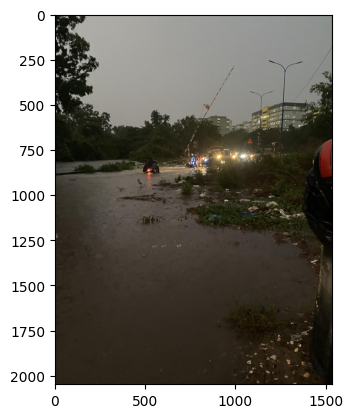

In [ ]:
path = '/kaggle/input/rainy-5/mua_5.jpg'
img = Image.open(path)
img = np.array(img)
plt.imshow(img)